
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [3]:
#Dropout: 0, 10%
DROPOUT = 0.10

#Learning rate: 2.5e-5 e 5e-5
LEARNING_RATE = 5e-5

TRAIN_NUM = '04'

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModel.from_pretrained("xlm-roberta-large")

In [5]:
df = pd.read_csv('../datasets/buscape_preprocessed.csv')

In [6]:
df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


In [7]:
print(f'{df.shape[0]} instancias, {df.shape[1]} classes')

133632 instancias, 2 classes


#### Dividindo dataset em dois batchs, 50% cada

In [8]:
reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [9]:
print(f'batch_01: {reviews_batch_01.shape[0]} instancias')
print(f'batch_02: {reviews_batch_02.shape[0]} instancias')

batch_01: 66816 instancias
batch_02: 66816 instancias


#### Quantidade de avaliações positivas e negativas no batch_01

In [10]:
labels_batch_01.value_counts()

rating
1    33477
0    33339
Name: count, dtype: int64

In [11]:
reviews = reviews_batch_01
labels = labels_batch_01

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [12]:
embeddings = []
for review in tqdm((reviews), desc='Processing'):
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing:  62%|██████▏   | 41485/66816 [5:35:14<3:24:41,  2.06it/s] 


KeyboardInterrupt: 

In [87]:
embeddings_array = np.vstack(embeddings)

In [88]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

35758 embeddings de 1024 dimensões


#### Feature based 1

In [89]:
additional_features = np.array([[len(str(review).split())] for review in reviews_batch_02])

In [90]:
print(embeddings_array.shape)
print(additional_features.shape)

(35758, 1024)
(35758, 1)


#### Combinando embeddings_array e additional_features

In [91]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [92]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [93]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [94]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [95]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 24)                24624     
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 24,649
Trainable params: 24,649
Non-trainable params: 0
_________________________________________________________________


In [96]:
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

In [97]:
tlm_gran_fb1_weights_path = './weights/b2w_tlm_gran_fb1_mlp_weights.hdf5'
model = load_weights_from_hdf5(model, tlm_gran_fb1_weights_path)

In [98]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [99]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [100]:
#CHECKPOINT=ModelCheckpoint(filepath='./weights/b2w_tlm_gran_fb1_mlp_weights.hdf5', verbose=1, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]


#### Treinamento do modelo

In [101]:
fold = 0
# -------------------------------------------------------------------
fold_train_losses = []
fold_train_accuracies = []
fold_train_f1_scores = []

train_tprs = []
train_aucs = []
train_mean_fpr = np.linspace(0, 1, 100)
# -------------------------------------------------------------------

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []

for train_indices, val_indices in tqdm((kf.split(combined_features)),desc="Processing"):
    fold+=1
    print(f'fold = {fold}')
    
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=5, 
        batch_size=32, 
        verbose=0,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    # -------------------------------------------------------------------
    
    # train prediction
    y_pred_train = model.predict(X_train_fold_tensor)
    y_pred_train_binary = np.round(y_train_fold)
    
    # train fold losses
    fold_train_losses.append(model_history.history['val_loss'])
    
    # train accuracy each fold
    fold_train_accuracies.append(model_history.history['accuracy'])
    
    # train f1 score each fold
    fold_train_f1_scores.append(f1_score(y_train_fold_tensor, y_pred_train_binary))
    
    # train roc curve and auc
    fpr, tpr, thresholds = roc_curve(y_train_fold_tensor, y_pred_train)
    roc_auc = auc(fpr, tpr)
    train_tprs.append(np.interp(train_mean_fpr, fpr, tpr))
    train_aucs.append(roc_auc)
    
    # -------------------------------------------------------------------
    
    # val predictions
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    # val acc each fold
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    # val f1 score each fold
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    # -------------------------------------------------------------------
    
print('Treinamento Finalizado!')

Processing: 0it [00:00, ?it/s]

fold = 1
112/112 [==============================] - 0s 778us/step


Processing: 1it [00:08,  8.66s/it]

fold = 2
112/112 [==============================] - 0s 778us/step


Processing: 2it [00:16,  8.10s/it]

fold = 3
112/112 [==============================] - 0s 777us/step


Processing: 3it [00:24,  8.02s/it]

fold = 4
112/112 [==============================] - 0s 759us/step


Processing: 4it [00:31,  7.86s/it]

fold = 5
112/112 [==============================] - 0s 951us/step


Processing: 5it [00:39,  7.88s/it]

fold = 6
112/112 [==============================] - 0s 790us/step


Processing: 6it [00:47,  7.82s/it]

fold = 7
112/112 [==============================] - 0s 778us/step


Processing: 7it [00:54,  7.42s/it]

fold = 8
112/112 [==============================] - 0s 765us/step


Processing: 8it [01:02,  7.63s/it]

fold = 9
112/112 [==============================] - 0s 786us/step


Processing: 9it [01:09,  7.64s/it]

fold = 10
112/112 [==============================] - 0s 767us/step


Processing: 10it [01:17,  7.78s/it]

Treinamento Finalizado!


In [102]:
print(f'train mean f1 score: {np.mean(fold_train_f1_scores)}')

train_accuracy_mean_value = round(np.mean([np.mean(train_ac) for train_ac in fold_train_accuracies]),4)
print(f'train mean accuracies: {train_accuracy_mean_value}')
print('-'*80)
print(f'validation mean f1 score: {np.mean(fold_f1_scores)}')
print(f'validation mean accuracies: {np.mean(fold_accuracies)}')

train mean f1 score: 1.0
train mean accuracies: 0.9449
--------------------------------------------------------------------------------
validation mean f1 score: 0.9467844449792879
validation mean accuracies: 0.9473406548708561


In [84]:
graph_path = 'b2w_08_tlm_gran_fb1_mlp_train_03'

In [85]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'./graphs/{graph_path}/train_test_{metric}.png')
    plt.show()

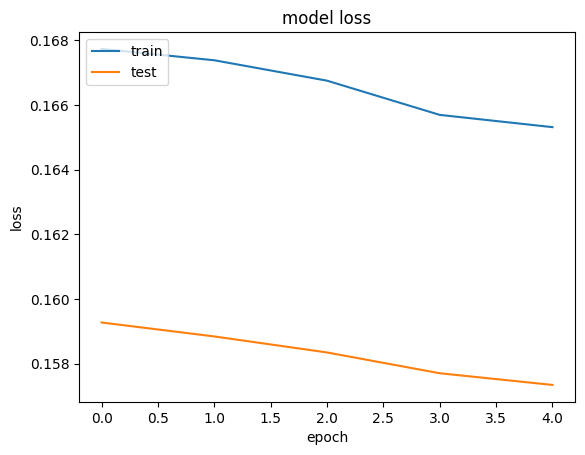

In [86]:
plot_eval_metrics(model_history, 'loss')

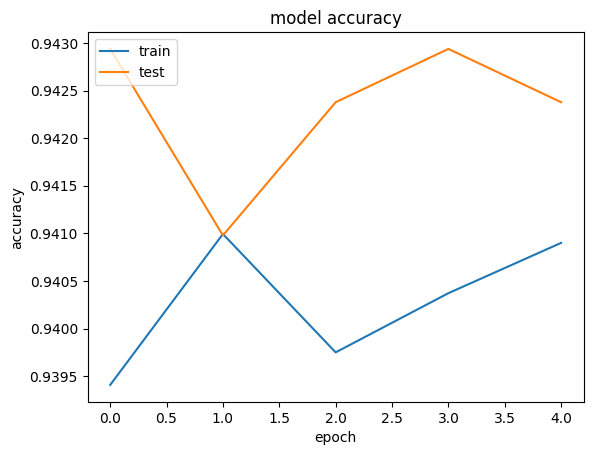

In [87]:
plot_eval_metrics(model_history, 'accuracy')

In [88]:
def plot_train_folds(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'./graphs/{graph_path}/train_folds_{metric}.png')
    plt.show()

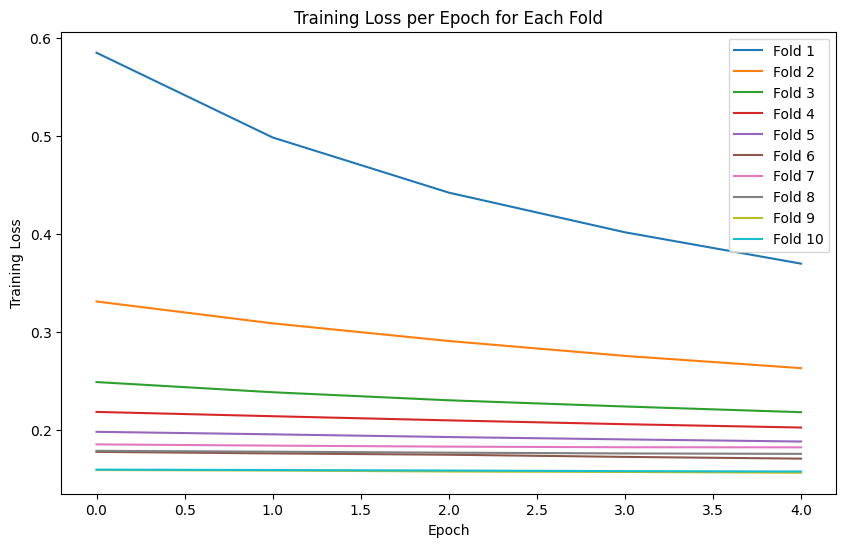

In [89]:
plot_train_folds(fold_train_losses, 'Loss')

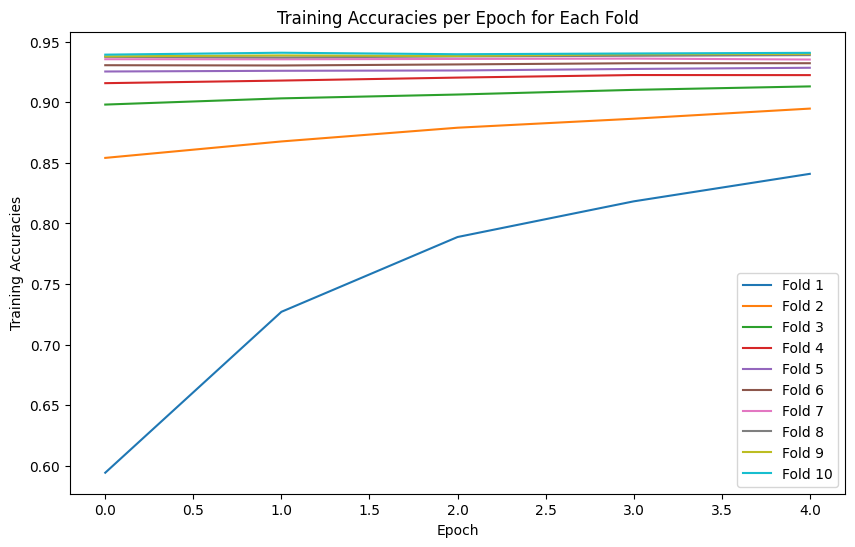

In [90]:
plot_train_folds(fold_train_accuracies, 'Accuracies')